In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist

import tyxe

In [3]:
pyro.set_rng_seed(42)

In [4]:
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(50, 1) * 0.5 + 0.5
x = torch.cat([x1, x2])
y = x.mul(4).add(0.8).cos() + 0.1 * torch.randn_like(x)

x_test = torch.linspace(-2, 2, 401).unsqueeze(-1)
y_test = x_test.mul(4).add(0.8).cos()

In [5]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

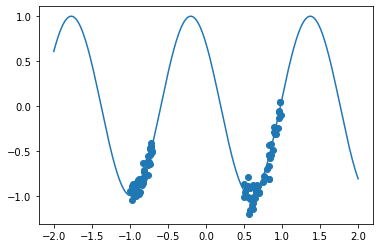

In [6]:
plt.scatter(x.squeeze(), y)
plt.plot(x_test.squeeze(), y_test)

In [7]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.observation_models.HomoskedasticGaussian(len(x), scale=0.1)
guide = tyxe.guides.ParameterwiseDiagonalNormal
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide)

In [8]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    elbos.append(e)
    
with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 10000, callback)

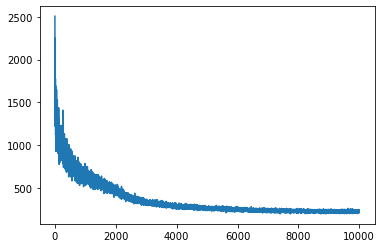

In [9]:
plt.plot(elbos)

In [11]:
m, sd = bnn.predict(x_test, num_predictions=32)

(-2.0, 2.0)

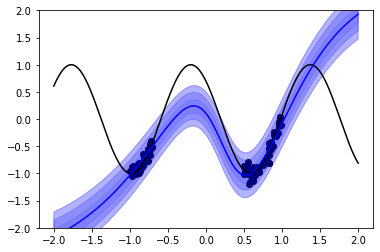

In [12]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

In [14]:
with tyxe.poutine.local_reparameterization():
    m, sd = bnn.predict(x_test, num_predictions=32)

torch.save((x, y, x_test, y_test, m, sd), "ffg_lr_predictions.pt")

(-2.0, 2.0)

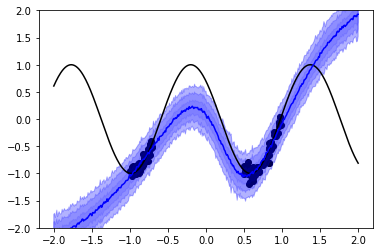

In [15]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

In [16]:
pyro.clear_param_store()
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.observation_models.HomoskedasticGaussian(len(x), scale=0.1)
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=50, target_accept_prob=0.7)
bnn = tyxe.bnn.MCMC_BNN(net, prior, obs_model, kernel)

In [17]:
bnn.fit(loader, 100000, warmup_steps=20000)

Sample: 100%|██████████| 120000/120000 [11:30, 173.70it/s, step size=1.96e-02, acc. prob=0.907]


(-2.0, 2.0)

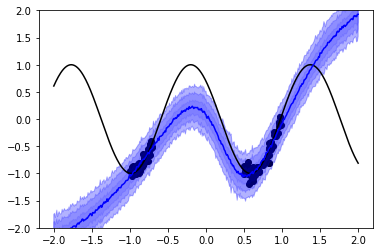

In [18]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

(-2.0, 2.0)

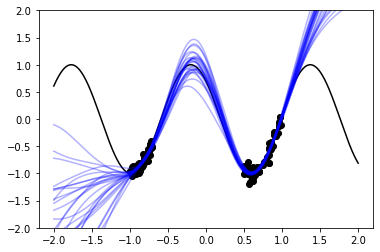

In [19]:
sampled_predictions = bnn.predict(x_test, num_predictions=25, aggregate=False)
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="blue", alpha=0.3)
plt.ylim(-2, 2)

In [20]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
optim = torch.optim.Adam(net.parameters(), 1e-4)
for _ in range(10000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

(-2.0, 2.0)

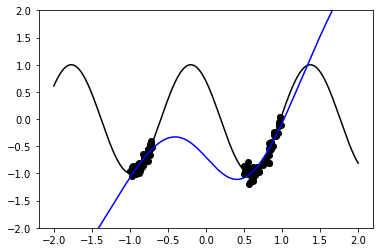

In [21]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, net(x_test).detach(), color="blue")
plt.ylim(-2, 2)